# Cats & Dogs Classification

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import os
import shutil
import random
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import torch
import torchvision
from PIL import Image

In [2]:
#Set up Device Agnostic Code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## 1. Exploratory Data Analysis

### 1.1 Setup Directories

In [3]:
#Setup Directories
src_dir = '/kaggle/input/dogs-vs-cats-csec-307'
src_train_dir = os.path.join(src_dir, "train/train")
src_test_dir = os.path.join(src_dir, "test1/test1")
os.listdir(src_dir)

['sampleSubmission.csv', 'test1', 'train']

### 1.2 Convert to DataFrame

In [4]:
# (1 = dog, 0 = cat)
filenames = os.listdir(src_train_dir)
labels = [ 1 if 'dog' in x else 0 for x in filenames if 'cat' in x or 'dog' in x ]

data = pd.DataFrame({"filename": filenames, "label": labels})

data.head()

,filename,label
0,cat.12461.jpg,0
1,dog.3443.jpg,1
2,dog.7971.jpg,1
3,dog.10728.jpg,1
4,dog.1942.jpg,1


In [5]:
data.shape

(25000, 2)

### 1.3 Visualize Dogs and Cats

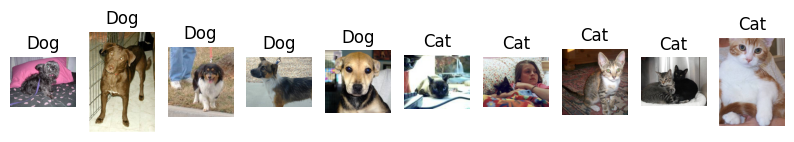

In [6]:
plt.figure(figsize=(10,10)) 

for i in range(10):
    plt.subplot(1, 10,i+1)    # the number of images in the grid is 10*10 (100)
    if i < 5:
        filename = src_train_dir + '/dog.' + str(i) + '.jpg'
        image = Image.open(filename)
        plt.imshow(image)
        plt.title('Dog',fontsize=12)
        plt.axis('off')
    else:
        filename = src_train_dir + '/cat.' + str(i) + '.jpg'
        image = Image.open(filename)
        plt.imshow(image)
        plt.title('Cat',fontsize=12)
        plt.axis('off')
plt.show()

## 2. Preprocess Data

### 2.1 Train Test Split

In [7]:
#Define Desitnation Folder
dataset_home = '/kaggle/working/dogs_vs_cats/'
train_dir = os.path.join(dataset_home, "train")
test_dir = os.path.join(dataset_home, "test")

In [8]:
for sub_dir in ['train/', 'test/']:
    # create label subdirectories
    for label_dir in ['dogs/', 'cats/']:
        newdir = dataset_home + sub_dir + label_dir
        os.makedirs(newdir, exist_ok=True) # Create 4 directories

random.seed(42)
split_ratio = 0.2

#Split Train Test Data
for file in os.listdir(src_train_dir):
        src = src_train_dir + '/' + file
        dst_dir = 'train/'
        if random.random() < split_ratio:
            dst_dir = 'test/'
        if file.startswith('cat'):
            dst = dataset_home + dst_dir + 'cats/' + file
            shutil.copyfile(src, dst)
        elif file.startswith('dog'):
            dst = dataset_home + dst_dir + 'dogs/' + file
            shutil.copyfile(src, dst)

In [9]:
#Number of Data for each Category
print(len(os.listdir(os.path.join(train_dir, "dogs"))))
print(len(os.listdir(os.path.join(train_dir, "cats"))))
print(len(os.listdir(os.path.join(test_dir, "dogs"))))
print(len(os.listdir(os.path.join(test_dir, "cats"))))

9935
9972
2565
2528


### 2.2 Prepare Dataset and DataLoaders

In [10]:
#Create Transformation
from torchvision import datasets, transforms
IMAGE_SIZE = (244, 244)
train_transform = transforms.Compose([
                                       transforms.Resize(IMAGE_SIZE),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.5, 0.5, 0.5], 
                                                            [0.5, 0.5, 0.5])])
test_transform = transforms.Compose([
                                       transforms.Resize(IMAGE_SIZE),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.5, 0.5, 0.5], 
                                                            [0.5, 0.5, 0.5])])


In [11]:
#Apply Transformations to Train Dataset
BATCH_SIZE = 32
train_data = datasets.ImageFolder(train_dir, transform=train_transform)
test_data = datasets.ImageFolder(test_dir, transform=test_transform)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True)
class_names = train_data.classes
class_name_idx = train_data.class_to_idx

Image size: torch.Size([3, 244, 244])


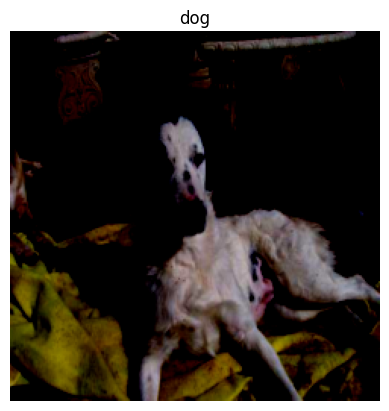

In [12]:
# Show a sample
torch.manual_seed(42)
train_features_batch, train_labels_batch = next(iter(train_loader))
random_idx = torch.randint(0, len(train_features_batch), size=[1]).item()
img, label = train_features_batch[random_idx], train_labels_batch[random_idx]
label_name = 'cat' if label == 0 else 'dog'
image = np.transpose(img, (1, 2, 0))
plt.imshow(image)
plt.title(label_name)
plt.axis("Off");
print(f"Image size: {img.shape}")

## 3. Build a Model

### 3.1 Use Resnet50

In [13]:
from torch import nn

model = torchvision.models.resnet50(pretrained=True)
for param in model.parameters():
    param.requires_grad = False

classifier = nn.Sequential(
                       nn.Linear(2048, 1000),
                       nn.ReLU(),
                       nn.Dropout(p=0.2),
                       nn.Linear(1000, 64),
                       nn.ReLU(),
                       nn.Dropout(p=0.2),
                       nn.Linear(64, 2),                           
                       nn.LogSoftmax(dim=1)
                    )
model.fc = classifier

model = model.to(device)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 168MB/s]


In [14]:
# Check out what's inside the training dataloader
train_features_batch, train_labels_batch = next(iter(train_loader))
train_features_batch.shape, train_labels_batch.shape

img_single, label_single = train_features_batch[3].unsqueeze(dim=0), train_labels_batch[3]
print(f"Single image shape: {img_single.shape}\n")

# Perform a forward pass on a single image
model.eval()
with torch.inference_mode():
    pred = model(img_single.to(device))
    
# Print out what's happening
print(f"Output logits:\n{pred}\n")
print(f"Output prediction probabilities:\n{torch.softmax(pred, dim=1)}\n")
print(f"Output prediction label:\n{torch.argmax(torch.softmax(pred, dim=1), dim=1)}\n")
print(f"Actual label:\n{label_single} ({class_names[label_single]})")

Single image shape: torch.Size([1, 3, 244, 244])

Output logits:
tensor([[-0.7452, -0.6437]], device='cuda:0')

Output prediction probabilities:
tensor([[0.4746, 0.5254]], device='cuda:0')

Output prediction label:
tensor([1], device='cuda:0')

Actual label:
0 (cats)


### 3.2 Setup Loss, Optimizer, And Evaluation Metrics

### 3.2.1 Setup Loss Function and Optimizer

In [15]:
# Setup loss function and optimizer
loss_fn = nn.NLLLoss()
optimizer = torch.optim.Adam(params = model.parameters(),lr =0.001)

### 3.2.2 Accuracy Function

In [16]:
#(https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py)
def accuracy_fn(y_true, y_pred):
    """Calculates accuracy between truth labels and predictions.

    Args:
        y_true (torch.Tensor): Truth labels for predictions.
        y_pred (torch.Tensor): Predictions to be compared to predictions.

    Returns:
        [torch.float]: Accuracy value between y_true and y_pred, e.g. 78.45
    """
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

### 3.2.3 Timer Function

In [17]:
from timeit import default_timer as timer
def print_train_time(start: float, end: float, device: torch.device = None):
    """Prints difference between start and end time.

    Args:
        start (float): Start time of computation (preferred in timeit format).
        end (float): End time of computation.
        device ([type], optional): Device that compute is running on. Defaults to None.

    Returns:
        float: time between start and end in seconds (higher is longer).
    """
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time

### 3.3 Train Model through Batches

### 3.3.1 Train Step and Test Step Functions

In [18]:
from tqdm.auto import tqdm

def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
    train_loss, train_acc = 0, 0
    model.to(device)
    for batch, (X, y) in enumerate(tqdm(data_loader)):
        # Send data to GPU
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += accuracy_fn(y_true=y,
                                 y_pred=y_pred.argmax(dim=1)) # Go from logits -> pred labels

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

    # Calculate loss and accuracy per epoch and print out what's happening
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")

def test_step(data_loader: torch.utils.data.DataLoader,
              model: torch.nn.Module,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):
    test_loss, test_acc = 0, 0
    model.to(device)
    model.eval() # put model in eval mode
    # Turn on inference context manager
    with torch.inference_mode():
        for X, y in tqdm(data_loader):
            # Send data to GPU
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred = model(X)

            # 2. Calculate loss and accuracy
            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(y_true=y,
                y_pred=test_pred.argmax(dim=1) # Go from logits -> pred labels
            )

        # Adjust metrics and print out
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")

In [19]:
# Measure time
from timeit import default_timer as timer
from tqdm.auto import tqdm

train_time_start_model = timer()

# Train and test model
epochs = 3
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n---------")
    train_step(data_loader=train_loader,
        model=model,
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn,
        device=device
    )
    test_step(data_loader=test_loader,
        model=model,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn,
        device=device
    )

train_time_end_model = timer()
total_train_time_model = print_train_time(start=train_time_start_model,
                                           end=train_time_end_model,
                                           device=device)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
---------


  0%|          | 0/623 [00:00<?, ?it/s]

Train loss: 0.04548 | Train accuracy: 98.42%


  0%|          | 0/160 [00:00<?, ?it/s]

Test loss: 0.02615 | Test accuracy: 99.04%

Epoch: 1
---------


  0%|          | 0/623 [00:00<?, ?it/s]

Train loss: 0.03466 | Train accuracy: 98.75%


  0%|          | 0/160 [00:00<?, ?it/s]

Test loss: 0.02812 | Test accuracy: 99.18%

Epoch: 2
---------


  0%|          | 0/623 [00:00<?, ?it/s]

Train loss: 0.02779 | Train accuracy: 99.04%


  0%|          | 0/160 [00:00<?, ?it/s]

Test loss: 0.02196 | Test accuracy: 99.22%

Train time on cuda: 425.662 seconds


### 3.4 Export Model

In [20]:
MODEL_PATH = os.path.join(dataset_home, 'model/')
os.makedirs(MODEL_PATH, exist_ok=True)

torch.save(model.state_dict(), os.path.join(MODEL_PATH, 'model.pth'))

## 4. Make predictions and get Model's results

## 4.1 Evaluate Model's Performance

In [21]:
# Model Evaluation Function
def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn):
    """Returns a dictionary containing the results of model predicting on data_loader.

    Args:
        model (torch.nn.Module): A PyTorch model capable of making predictions on data_loader.
        data_loader (torch.utils.data.DataLoader): The target dataset to predict on.
        loss_fn (torch.nn.Module): The loss function of model.
        accuracy_fn: An accuracy function to compare the models predictions to the truth labels.

    Returns:
        (dict): Results of model making predictions on data_loader.
    """
    loss, acc = 0, 0
    model.eval()
    device = next(model.parameters()).device  # Get the device of the model's parameters
    with torch.inference_mode():
        for X, y in tqdm(data_loader):
            # Move input tensors to the same device as the model's parameters
            X, y = X.to(device), y.to(device)

            # Make predictions with the model
            y_pred = model(X)

            # Accumulate the loss and accuracy values per batch
            loss += loss_fn(y_pred, y).item()
            acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))

        # Scale loss and acc to find the average loss/acc per batch
        loss /= len(data_loader)
        acc /= len(data_loader)

    return {"model_name": model.__class__.__name__,
            "model_loss": loss,
            "model_acc": acc}

In [22]:
model_results = eval_model(
    model=model,
    data_loader=test_loader,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn
)
model_results

  0%|          | 0/160 [00:00<?, ?it/s]

{'model_name': 'ResNet',
 'model_loss': 0.022786911721823344,
 'model_acc': 99.11328125}

## 4.2 Make Predictions

In [23]:
import random
random.seed(42)
test_samples = []
test_labels = []
for sample, label in random.sample(list(test_data), k=20):
    test_samples.append(sample)
    test_labels.append(label)

# View the first test sample shape and label
print(f"Test sample image shape: {test_samples[0].shape}\nTest sample label: {test_labels[0]} ({class_names[test_labels[0]]})")

Test sample image shape: torch.Size([3, 244, 244])
Test sample label: 0 (cats)


In [24]:
y_preds = []
model.eval()
with torch.inference_mode():
  for X, y in tqdm(test_loader, desc="Making predictions"):
    # Send data and targets to target device
    X, y = X.to(device), y.to(device)
    # Do the forward pass
    y_logit = model(X)
    # Turn predictions from logits -> prediction probabilities -> predictions labels
    y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1) # note: perform softmax on the "logits" dimension, not "batch" dimension (in this case we have a batch size of 32, so can perform on dim=1)
    # Put predictions on CPU for evaluation
    y_preds.append(y_pred.cpu())

Making predictions:   0%|          | 0/160 [00:00<?, ?it/s]

In [25]:
# Concatenate list of predictions into a tensor
y_pred_tensor = torch.cat(y_preds)


### 4.2.1 Visualize Predictions

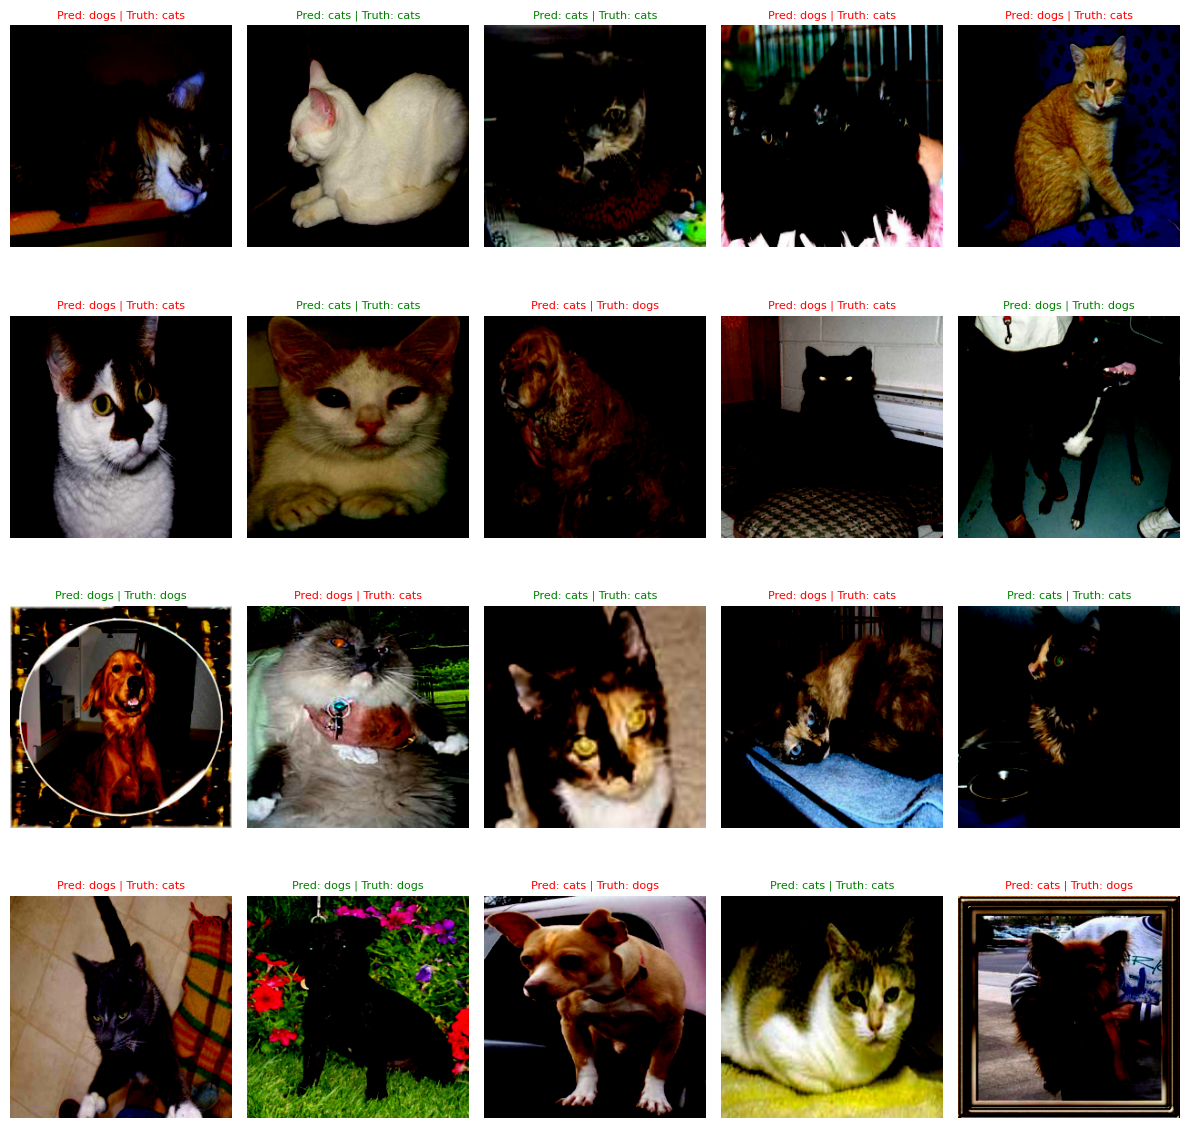

In [26]:
import matplotlib.pyplot as plt

# Plot predictions
plt.figure(figsize=(12, 12))
nrows = 4
ncols = 5
num_samples = 20  # Total number of samples to display

for i in range(num_samples):
    sample = test_samples[i]
    pred_label = class_names[y_pred_tensor[i]]
    truth_label = class_names[test_labels[i]]
    title_text = f"Pred: {pred_label} | Truth: {truth_label}"

    # Create a subplot
    plt.subplot(nrows, ncols, i+1)

    # Plot the target image
    plt.imshow(np.transpose(sample, (1, 2, 0)))

    # Check for equality and change title colour accordingly
    if pred_label == truth_label:
        plt.title(title_text, fontsize=8, c="g")  # green text if correct
    else:
        plt.title(title_text, fontsize=8, c="r")  # red text if wrong
    plt.axis(False)

plt.tight_layout()
plt.show()

### 4.2.2 Export Predictions to CSV

In [27]:
import pandas as pd
from PIL import Image 
from tqdm.auto import tqdm
import glob

# 1. Make predictions with trained model
results = []

model.eval()
print('Data load initiated')
files = [os.path.basename(f) for f in glob.glob(src_test_dir + '/*.jpg')]
for index, file in enumerate(tqdm(files)):
    img = Image.open(os.path.join(src_test_dir, file)).convert('RGB')
    img_tensor = test_transform(img).unsqueeze(0).to(device)
    
    #Make Prediction
    with torch.no_grad():
        output = model(img_tensor)
        _, predicted = torch.max(output, 1)
        label = predicted.item()
    
    #Add Data to Result
    results.append({
            'id': file.split('.')[0],
            'label': label
        })


Data load initiated


  0%|          | 0/12500 [00:00<?, ?it/s]

In [28]:
import pandas as pd

df = pd.DataFrame(results)
df.set_index('id', inplace=True)
print(df.head(10))
csv_path = os.path.join(dataset_home, 'submission.csv')
df.to_csv(csv_path)

       label
id          
7981       1
6234       0
1269       1
3863       0
6241       1
10304      1
623        0
2193       1
11925      0
3750       1


train_features_batch# 5. Export Predictions to csv